In [1]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation, performance_metrics 

import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('../data/kaggle_energy/train_bid_1249.csv')
df_w = pd.read_csv('../data/kaggle_energy/weather_train_sid_14.csv')

df['timestamp'] = pd.to_datetime(df['timestamp'])
df_w['timestamp'] = pd.to_datetime(df_w['timestamp'])

df = df.merge(df_w)

# rename columns
df = df.rename(columns={'timestamp': 'ds', 'meter_reading': 'y'})

# change to daily
df_daily = df.set_index('ds').resample('D').sum().reset_index()

In [3]:
df_daily

,ds,building_id,meter,y,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,2016-01-01,28727,23,15443.183,322,90.5,10.0,-75.5,0.0,23408.2,6370.0,77.6
1,2016-01-02,29976,24,16283.297,336,42.3,18.0,-182.8,0.0,24420.7,6550.0,73.4
2,2016-01-03,29976,24,15749.432,336,36.6,0.0,-127.9,-1.0,24291.7,4950.0,64.9
3,2016-01-04,29976,24,14303.501,336,-21.6,8.0,-241.6,0.0,24363.2,7810.0,110.9
4,2016-01-05,29976,24,18413.965,336,-198.2,0.0,-464.3,0.0,24770.7,7360.0,111.9
...,...,...,...,...,...,...,...,...,...,...,...,...
361,2016-12-27,29976,24,23480.136,336,285.0,18.0,172.1,-2.0,24344.1,5110.0,113.7
362,2016-12-28,29976,24,20484.967,336,129.2,8.0,-88.7,0.0,24400.1,6390.0,76.2
363,2016-12-29,29976,24,19281.091,336,35.7,0.0,-37.9,58.0,23276.8,2960.0,42.3
364,2016-12-30,29976,24,19513.457,336,59.9,8.0,-124.4,0.0,24098.2,6530.0,112.2


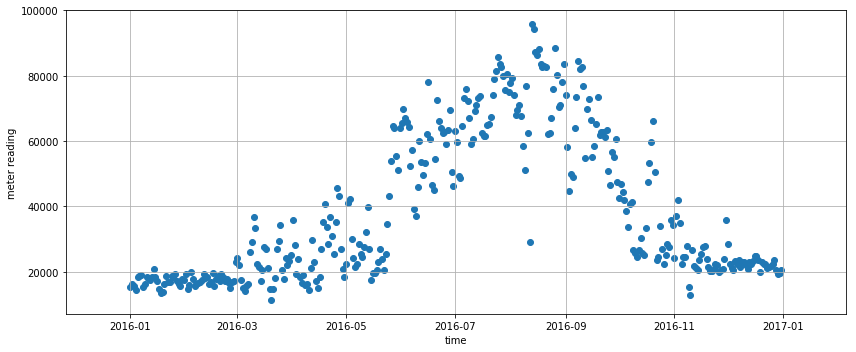

In [4]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.scatter(df_daily['ds'].to_numpy(), df_daily['y'].to_numpy())
plt.xlabel('time')
plt.ylabel('meter reading')
plt.grid(True)
plt.tight_layout()
plt.show()

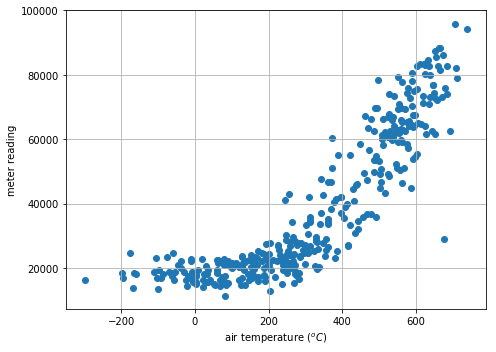

In [5]:
fig, ax = plt.subplots(figsize=(7, 5))
plt.scatter(df_daily['air_temperature'].to_numpy(), df_daily['y'].to_numpy())
plt.xlabel('air temperature ($^oC$)')
plt.ylabel('meter reading')
plt.grid(True)
plt.tight_layout()
plt.show()

# Normal Prophet

In [6]:
t = pd.Timestamp('2016-11-1')  # 10 months training vs. 2 months testing
df_train = df_daily[df_daily['ds'] < t]
df_test = df_daily[df_daily['ds'] >= t]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


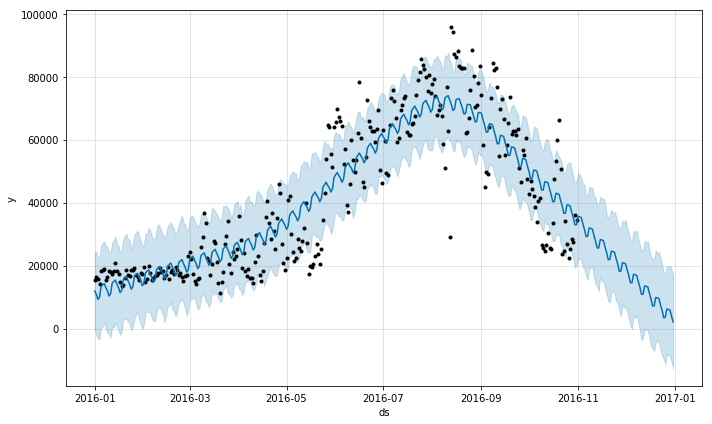

In [7]:
m = Prophet()
m.fit(df_train)

future = m.make_future_dataframe(periods=61)
forecast = m.predict(future)

fig = m.plot(forecast)

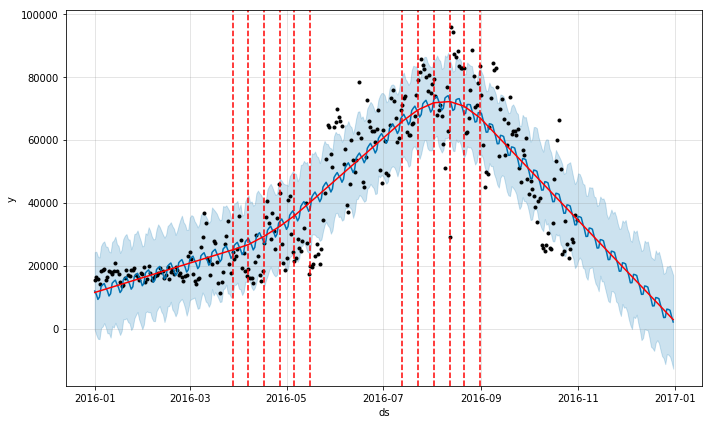

In [8]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

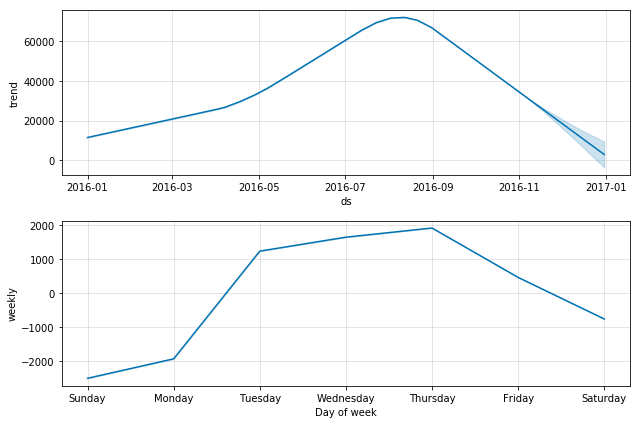

In [9]:
fig = m.plot_components(forecast)

In [10]:
# horizon: prediction horizon for each fold (how far how do you want to forecast?)
horizon = '60 days'

# initial: initial training period
initial = '305 days'  # use 5 years of daily data to train

# period: spacing between cutoff dates
period = '305 days'


m = Prophet()
m.add_regressor('air_temperature')
m.fit(df_daily)

df_cv = cross_validation(m, initial=initial, period=period, horizon=horizon)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-11-01 00:00:00 and 2016-11-01 00:00:00


In [11]:
df_metrics = performance_metrics(df_cv)
df_metrics.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,6 days,1.196162e+07,3458.557861,2416.084887,0.096104,0.036945,1.000000
1,7 days,1.141463e+07,3378.555041,2152.015463,0.089315,0.019943,1.000000
2,8 days,5.749062e+07,7582.257078,4922.994028,0.268614,0.122094,0.833333
3,9 days,9.111570e+07,9545.454536,7202.379088,0.448678,0.243628,0.666667
4,10 days,8.779816e+07,9370.067116,6735.551708,0.425454,0.173957,0.666667


In [12]:
df_metrics['rmse'].mean()

10172.399603717959

In [13]:
df_metrics['mape'].mean()

0.4216681937081896

# Add regressor

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


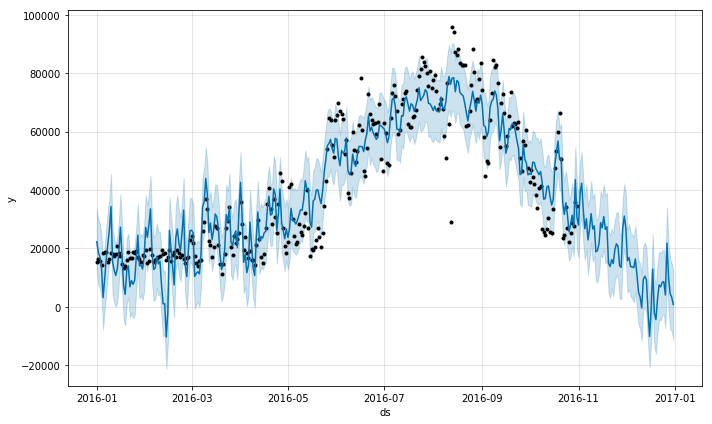

In [14]:
m = Prophet()
m.add_regressor('air_temperature') 
m.add_regressor('dew_temperature')
m.fit(df_train)

future = m.make_future_dataframe(periods=61)
future['air_temperature'] = df_daily['air_temperature']
future['dew_temperature'] = df_daily['dew_temperature']
forecast = m.predict(future)

fig = m.plot(forecast)

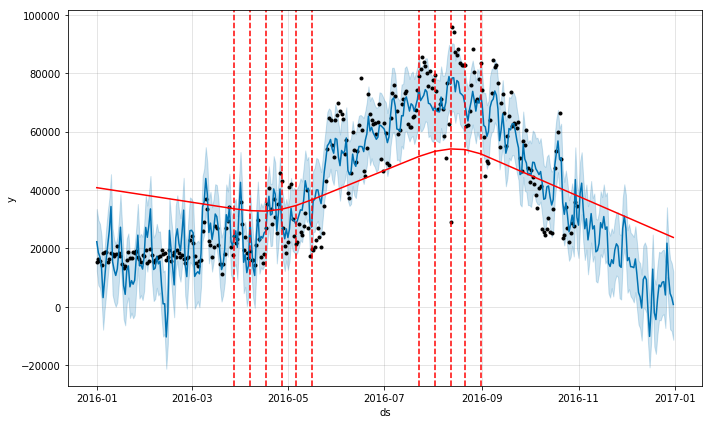

In [15]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

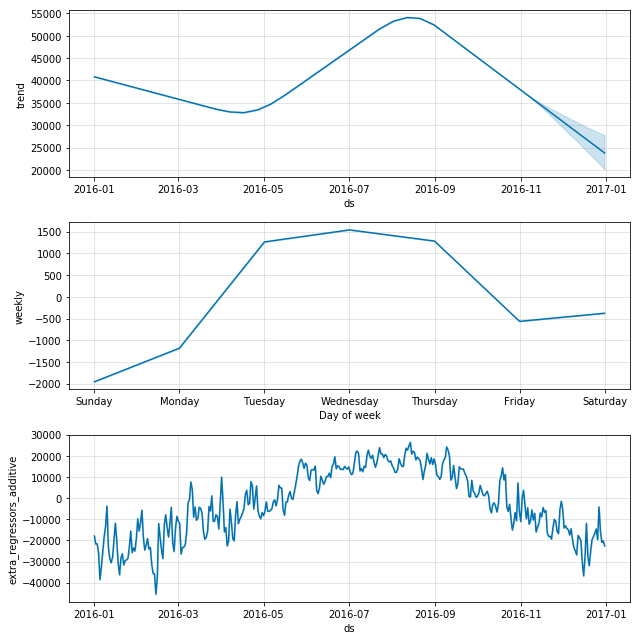

In [16]:
fig = m.plot_components(forecast)

In [17]:
from fbprophet.diagnostics import cross_validation, performance_metrics 
from fbprophet.plot import plot_cross_validation_metric

In [18]:
len(df_train), len(df_test)

(305, 61)

In [19]:
# horizon: prediction horizon for each fold (how far how do you want to forecast?)
horizon = '60 days'

# initial: initial training period
initial = '305 days'  # use 5 years of daily data to train

# period: spacing between cutoff dates
period = '305 days'


m = Prophet()
m.add_regressor('air_temperature')
m.fit(df_daily)

df_cv = cross_validation(m, initial=initial, period=period, horizon=horizon)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-11-01 00:00:00 and 2016-11-01 00:00:00


In [20]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-11-02,38788.408624,27897.080488,49977.493374,36960.510,2016-11-01
1,2016-11-03,42113.457429,31418.471298,53401.987909,42114.550,2016-11-01
2,2016-11-04,34264.164787,23605.766538,45510.118576,34801.920,2016-11-01
3,2016-11-05,27496.075459,16841.991299,38169.086213,22542.305,2016-11-01
4,2016-11-06,31157.386793,20247.201765,41411.472296,24581.744,2016-11-01


In [21]:
df_metrics = performance_metrics(df_cv)
df_metrics.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,6 days,1.196162e+07,3458.557861,2416.084887,0.096104,0.036945,1.000000
1,7 days,1.141463e+07,3378.555041,2152.015463,0.089315,0.019943,1.000000
2,8 days,5.749062e+07,7582.257078,4922.994028,0.268614,0.122094,0.833333
3,9 days,9.111570e+07,9545.454536,7202.379088,0.448678,0.243628,0.666667
4,10 days,8.779816e+07,9370.067116,6735.551708,0.425454,0.173957,0.666667


In [22]:
df_metrics['rmse'].mean()

10172.399603717959

In [23]:
df_metrics['mape'].mean()

0.4216681937081896

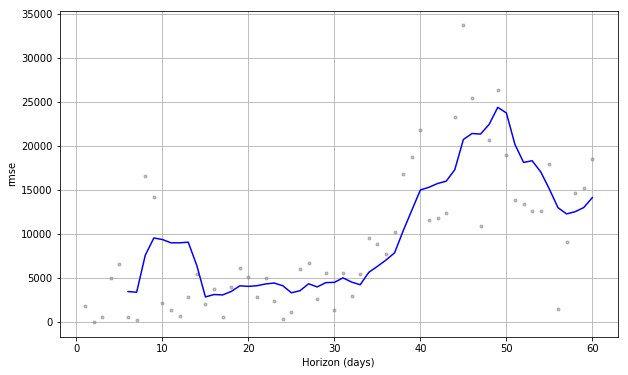

In [24]:
ax = plot_cross_validation_metric(df_cv, metric='rmse')